In [1]:
import os
import torch
import torch.nn as nn
import lightning.pytorch as pl

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from config import Config, configurations
from data.data import get_data, get_collator
from models.tiny_sleep_net import TinySleepNet
from model import SleepStagingModel

In [2]:
checkpoint_path = os.path.join("experiments_logs", "baseline", "version_1", "checkpoints", "epoch=199-step=1800.ckpt")

In [3]:
cfg: Config = configurations["baseline"]
*_, test_loader = get_data(
    root=cfg.data_dir,
    batch_size=cfg.batch_size,
    train_percentage=0.8,
    val_percentage=0.1,
    test_percentage=0.1,
    collate_fn=get_collator(low_resources=cfg.low_resources)
)

In [4]:

criterion = nn.CrossEntropyLoss(weight=torch.Tensor([1., 1.5, 1., 1., 1.]))
model = SleepStagingModel.load_from_checkpoint(
    checkpoint_path, 
    map_location=torch.device("cpu"),
    model=TinySleepNet(cfg),
    cost_function=criterion,
    config=cfg,
    evaluate=True
)
model.freeze()
trainer = pl.Trainer()

out = trainer.test(model, test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\febbr\Projects\5AUA0-Project4\venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


c:\Users\febbr\Projects\5AUA0-Project4\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\febbr\Projects\5AUA0-Project4\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\febbr\Projects\5AUA0-Project4\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Use

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Accuracy/Test       │     70.43478393554688     │
│         Loss/Test         │    0.7774681448936462     │
└───────────────────────────┴───────────────────────────┘

In [5]:
pd.DataFrame(model.results["report"]).T.applymap(lambda x: str(int(x)) if abs(x - int(x)) < 1e-6 else str(round(x,2))).to_latex("results.tex")

In [6]:
model.results["matrix"]

array([[132, 101,  42,   0,  25],
       [  8, 153,  45,   0,  34],
       [  0,  33, 368,   0,  43],
       [  0,   0,   0,   0,   0],
       [  0,  33,  14,   0,  89]], dtype=int64)

In [7]:
model.results["matrix_norm"]

array([[0.11785714, 0.09017857, 0.0375    , 0.        , 0.02232143],
       [0.00714286, 0.13660714, 0.04017857, 0.        , 0.03035714],
       [0.        , 0.02946429, 0.32857143, 0.        , 0.03839286],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.02946429, 0.0125    , 0.        , 0.07946429]])

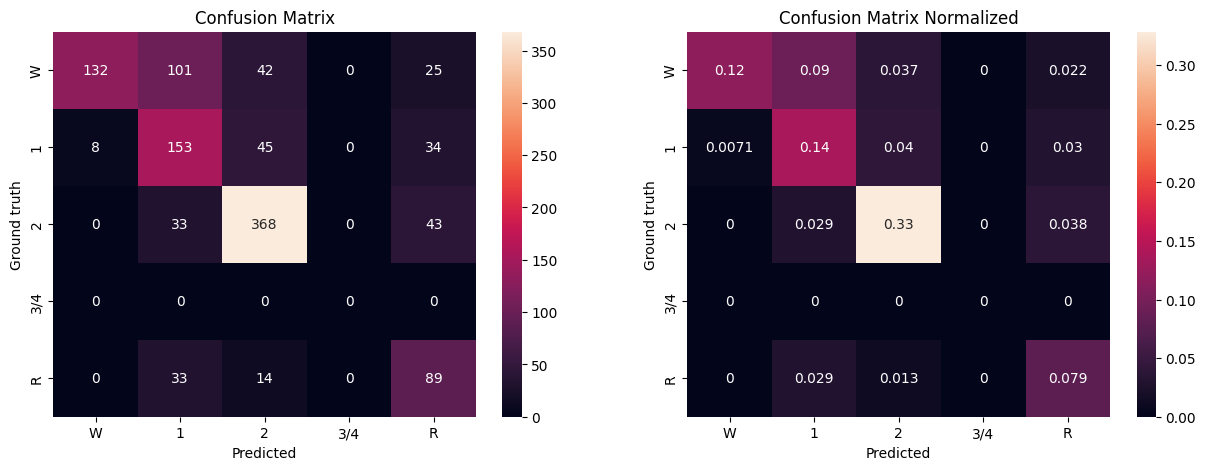

In [16]:
from data.prepare_sleepedf import label2ann
labels = [label[12:] for label in label2ann.values()]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(model.results["matrix"], annot=True, fmt="d",  ax=ax1, xticklabels=labels, yticklabels=labels)
ax1.set_title("Confusion Matrix")
ax1.set_xlabel("Predicted")
ax1.set_ylabel("Ground truth")
sns.heatmap(model.results["matrix_norm"], annot=True, ax=ax2, xticklabels=labels, yticklabels=labels)
ax2.set_title("Confusion Matrix Normalized")
ax2.set_xlabel("Predicted")
ax2.set_ylabel("Ground truth")
plt.show()